In [2]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pyLDAvis.lda_model
from sklearn.feature_extraction.text import TfidfVectorizer

## Preparing The Data

In [3]:
clean_messages_df = pd.read_pickle("messages_scraped_clean.pkl")

In [4]:
df = clean_messages_df[['lemmatized']]
df.head()

,lemmatized
0,"[milk, price, tracker, thread, beef, lamb, fee..."
1,"[christ, bad, enough, know, get, would, even, ..."
2,"[would, willing, interesting, see, variation, ..."
3,"[look, like, start]"
4,"[grr, low]"


In [5]:
df['lemmatized_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
df.head()

/tmp/ipykernel_40127/2939565254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]


,lemmatized,lemmatized_str
0,"[milk, price, tracker, thread, beef, lamb, fee...",milk price tracker thread beef lamb feed fert ...
1,"[christ, bad, enough, know, get, would, even, ...",christ bad enough know get would even worse kn...
2,"[would, willing, interesting, see, variation, ...",would willing interesting see variation aroumd...
3,"[look, like, start]",look like start
4,"[grr, low]",grr low


## Sentiment Analysis

In [6]:
df['sentiment'] = df['lemmatized_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

/tmp/ipykernel_40127/1326024020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['lemmatized_str'].apply(lambda x: TextBlob(x).sentiment.polarity)


,lemmatized,lemmatized_str,sentiment
0,"[milk, price, tracker, thread, beef, lamb, fee...",milk price tracker thread beef lamb feed fert ...,0.000
1,"[christ, bad, enough, know, get, would, even, ...",christ bad enough know get would even worse kn...,-0.225
2,"[would, willing, interesting, see, variation, ...",would willing interesting see variation aroumd...,0.375
3,"[look, like, start]",look like start,0.000
4,"[grr, low]",grr low,-0.350


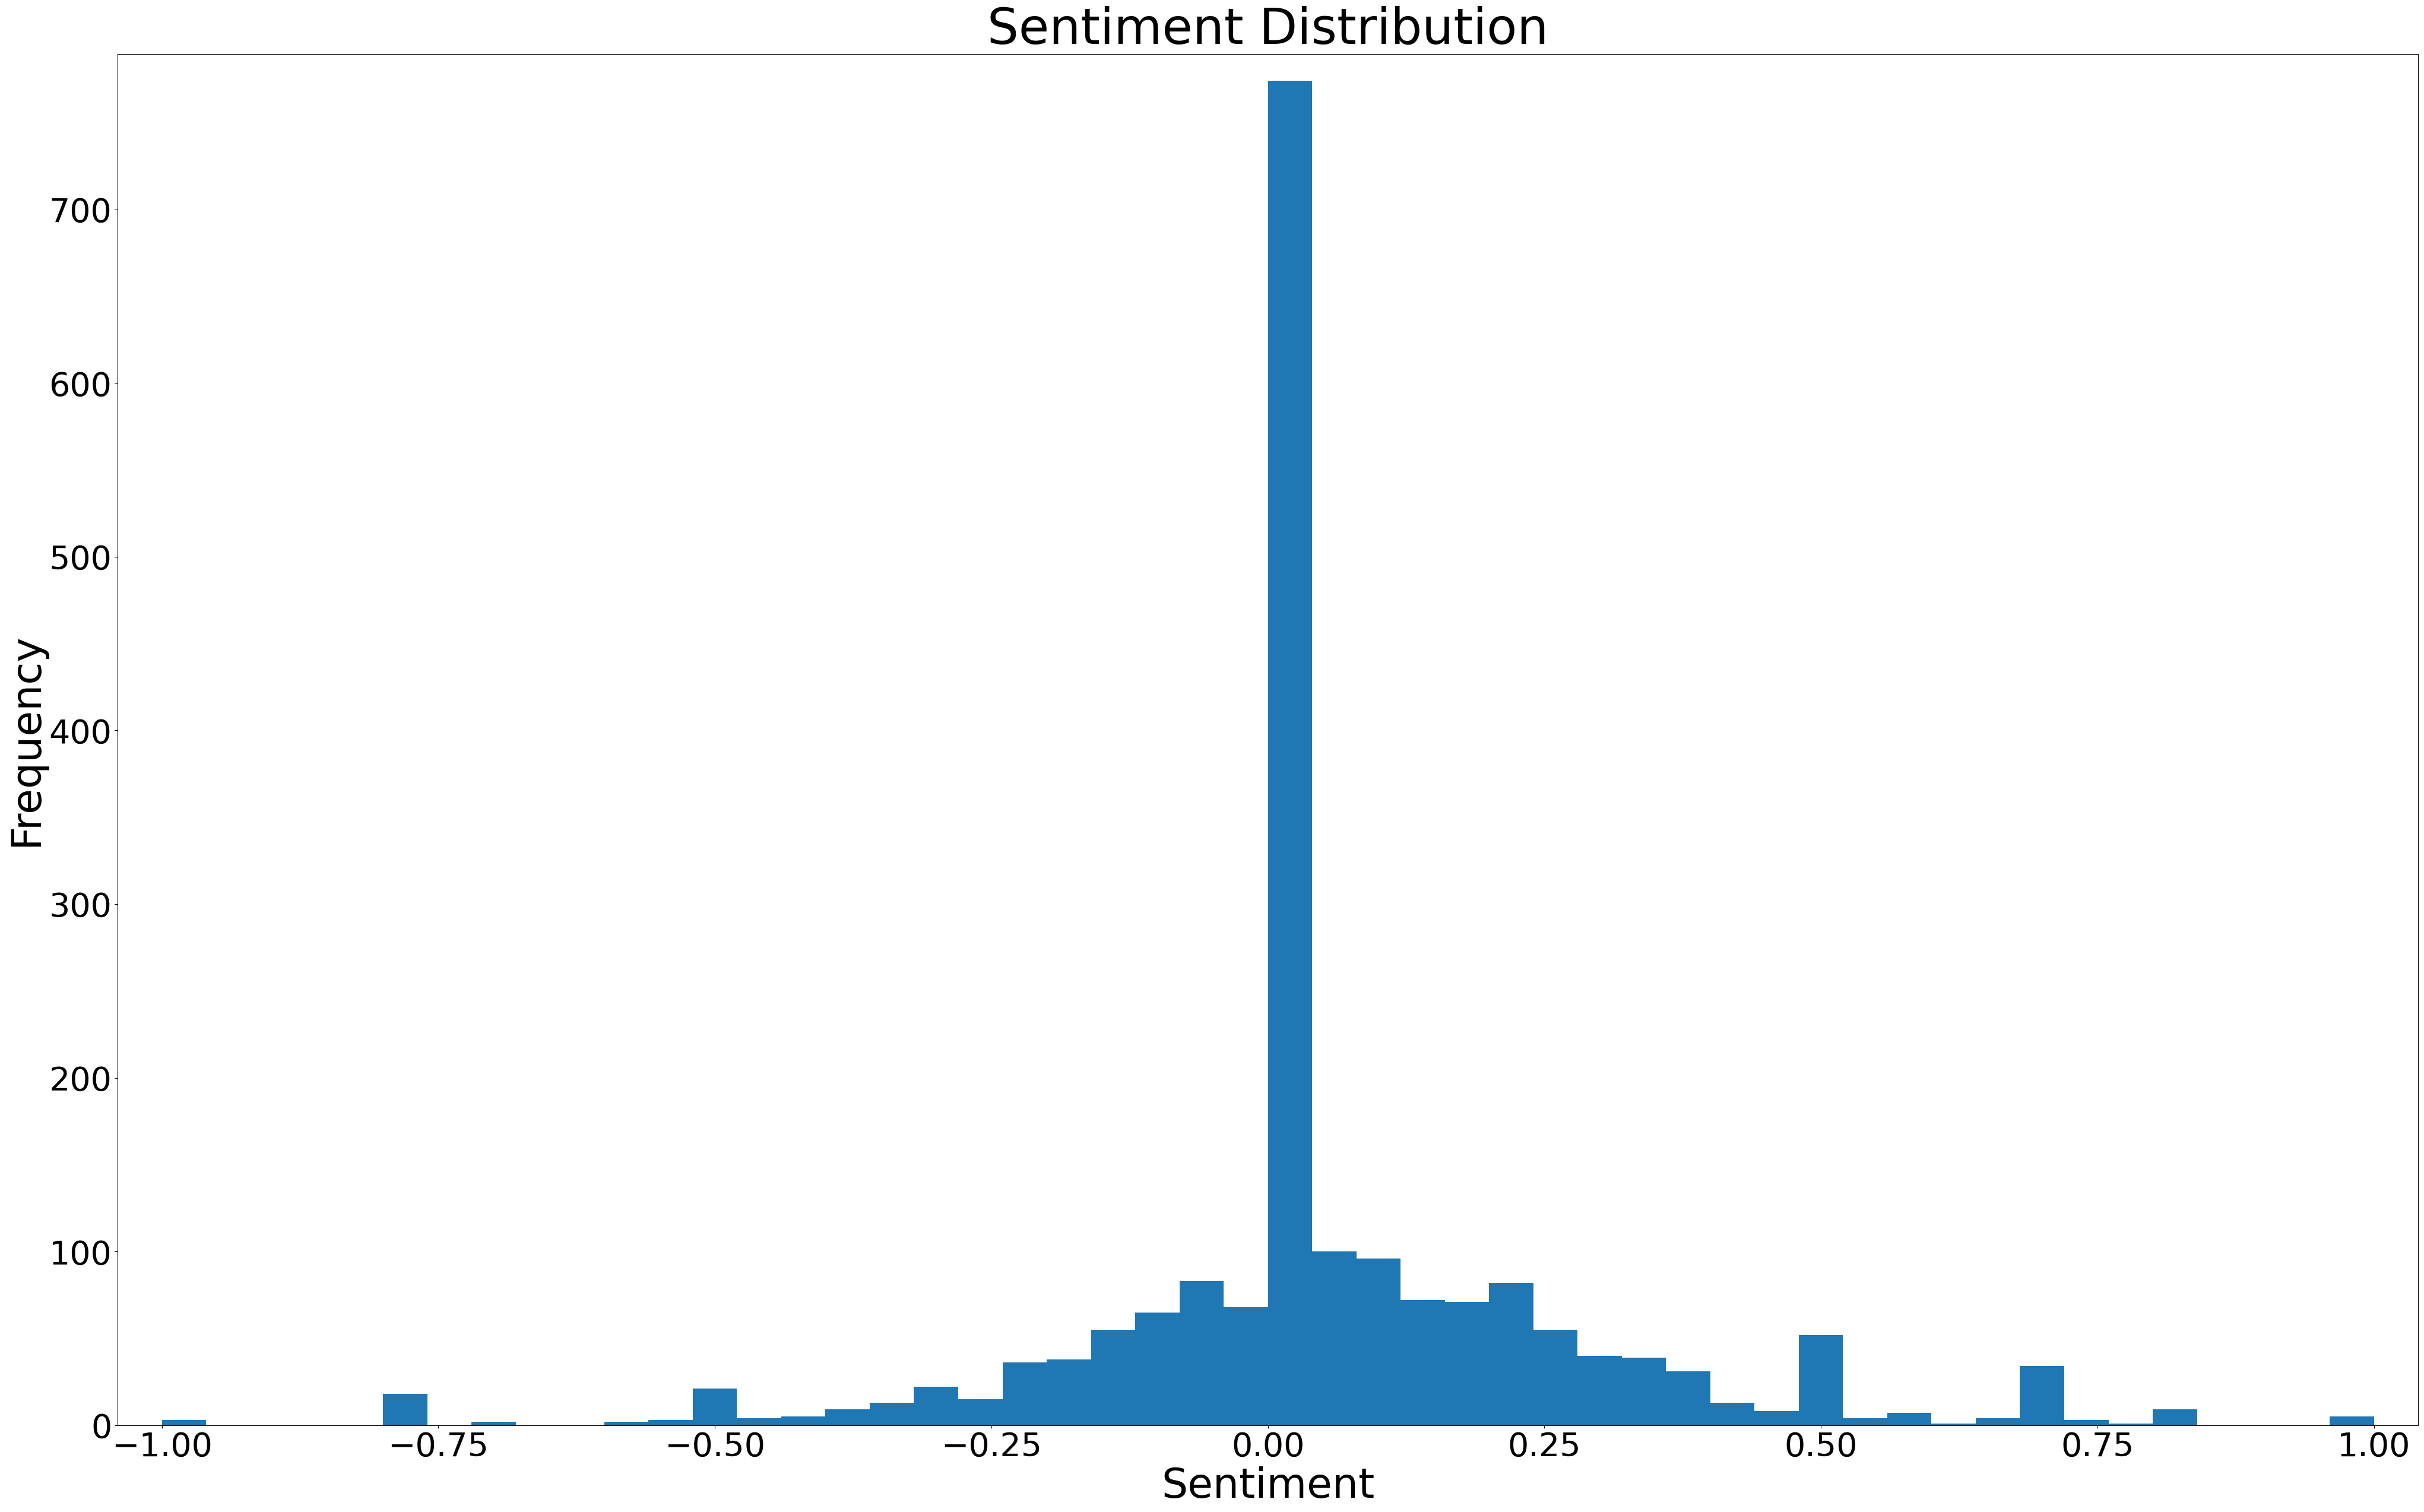

In [7]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

## Most Common Words

In [8]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)

['milk', 'price', 'tracker', 'thread', 'beef', 'lamb', 'feed', 'fert', 'combinables', 'spray', 'fuel', 'christ', 'bad', 'enough', 'know', 'get', 'would', 'even', 'worse', 'know', 'much', 'people', 'would', 'willing', 'interesting', 'see', 'variation', 'aroumd', 'country/companys', 'feb', 'milk', '23.79ppl', 'glanbia', 'look', 'like', 'start', 'grr', 'low', 'many', 'dairy', 'farmer', 'leave', 'soon', 'bit', 'pointless', 'speak', 'someone', 'yesterday', 'say', 'number', 'dairy', 'cow', 'remain', 'static', 'number', 'dairy', 'farmer', 'continue', 'decline', 'well', '............', 'begin', '1', 'retention', 'start', 'receive', 'till', 'april', 'pick', 'ball', '15', 'year', 'sector', 'improve', 'much', 'time', '29ppl', 'feb', '5.8', '3.8', 'aml', 'exactly', '10ppl', 'low', 'time', 'last', 'year', 'happy', 'start', 'one', 'think', 'would', 'enough', 'participation', 'think', 'dedicate', 'dairy', 'forum', 'would', 'appropriate', 'keep', 'dairy', 'stuff', 'group', 'together', 'pay', 'quality'

/home/mahdi/myfiles/The Search!/Risk Measurement with NLP/Topic_Extractor/env/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


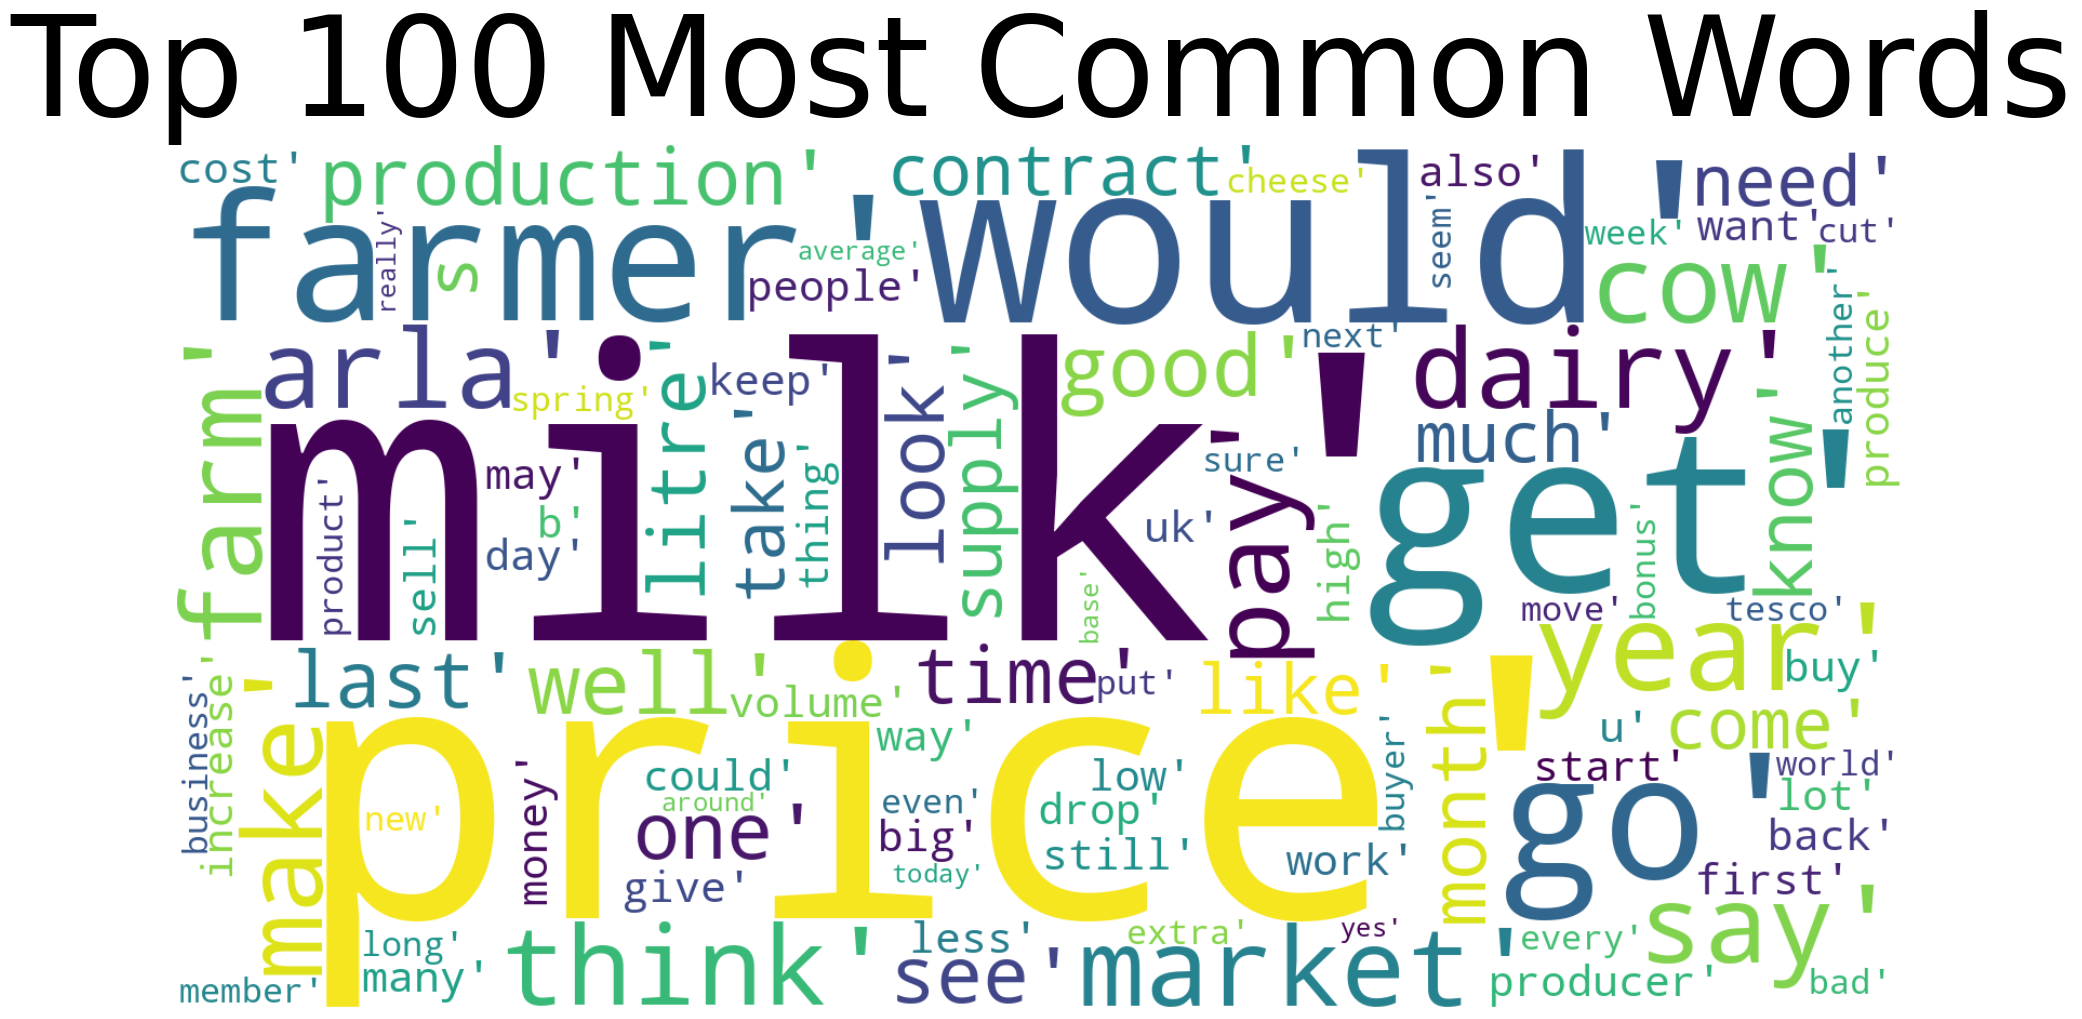

In [9]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

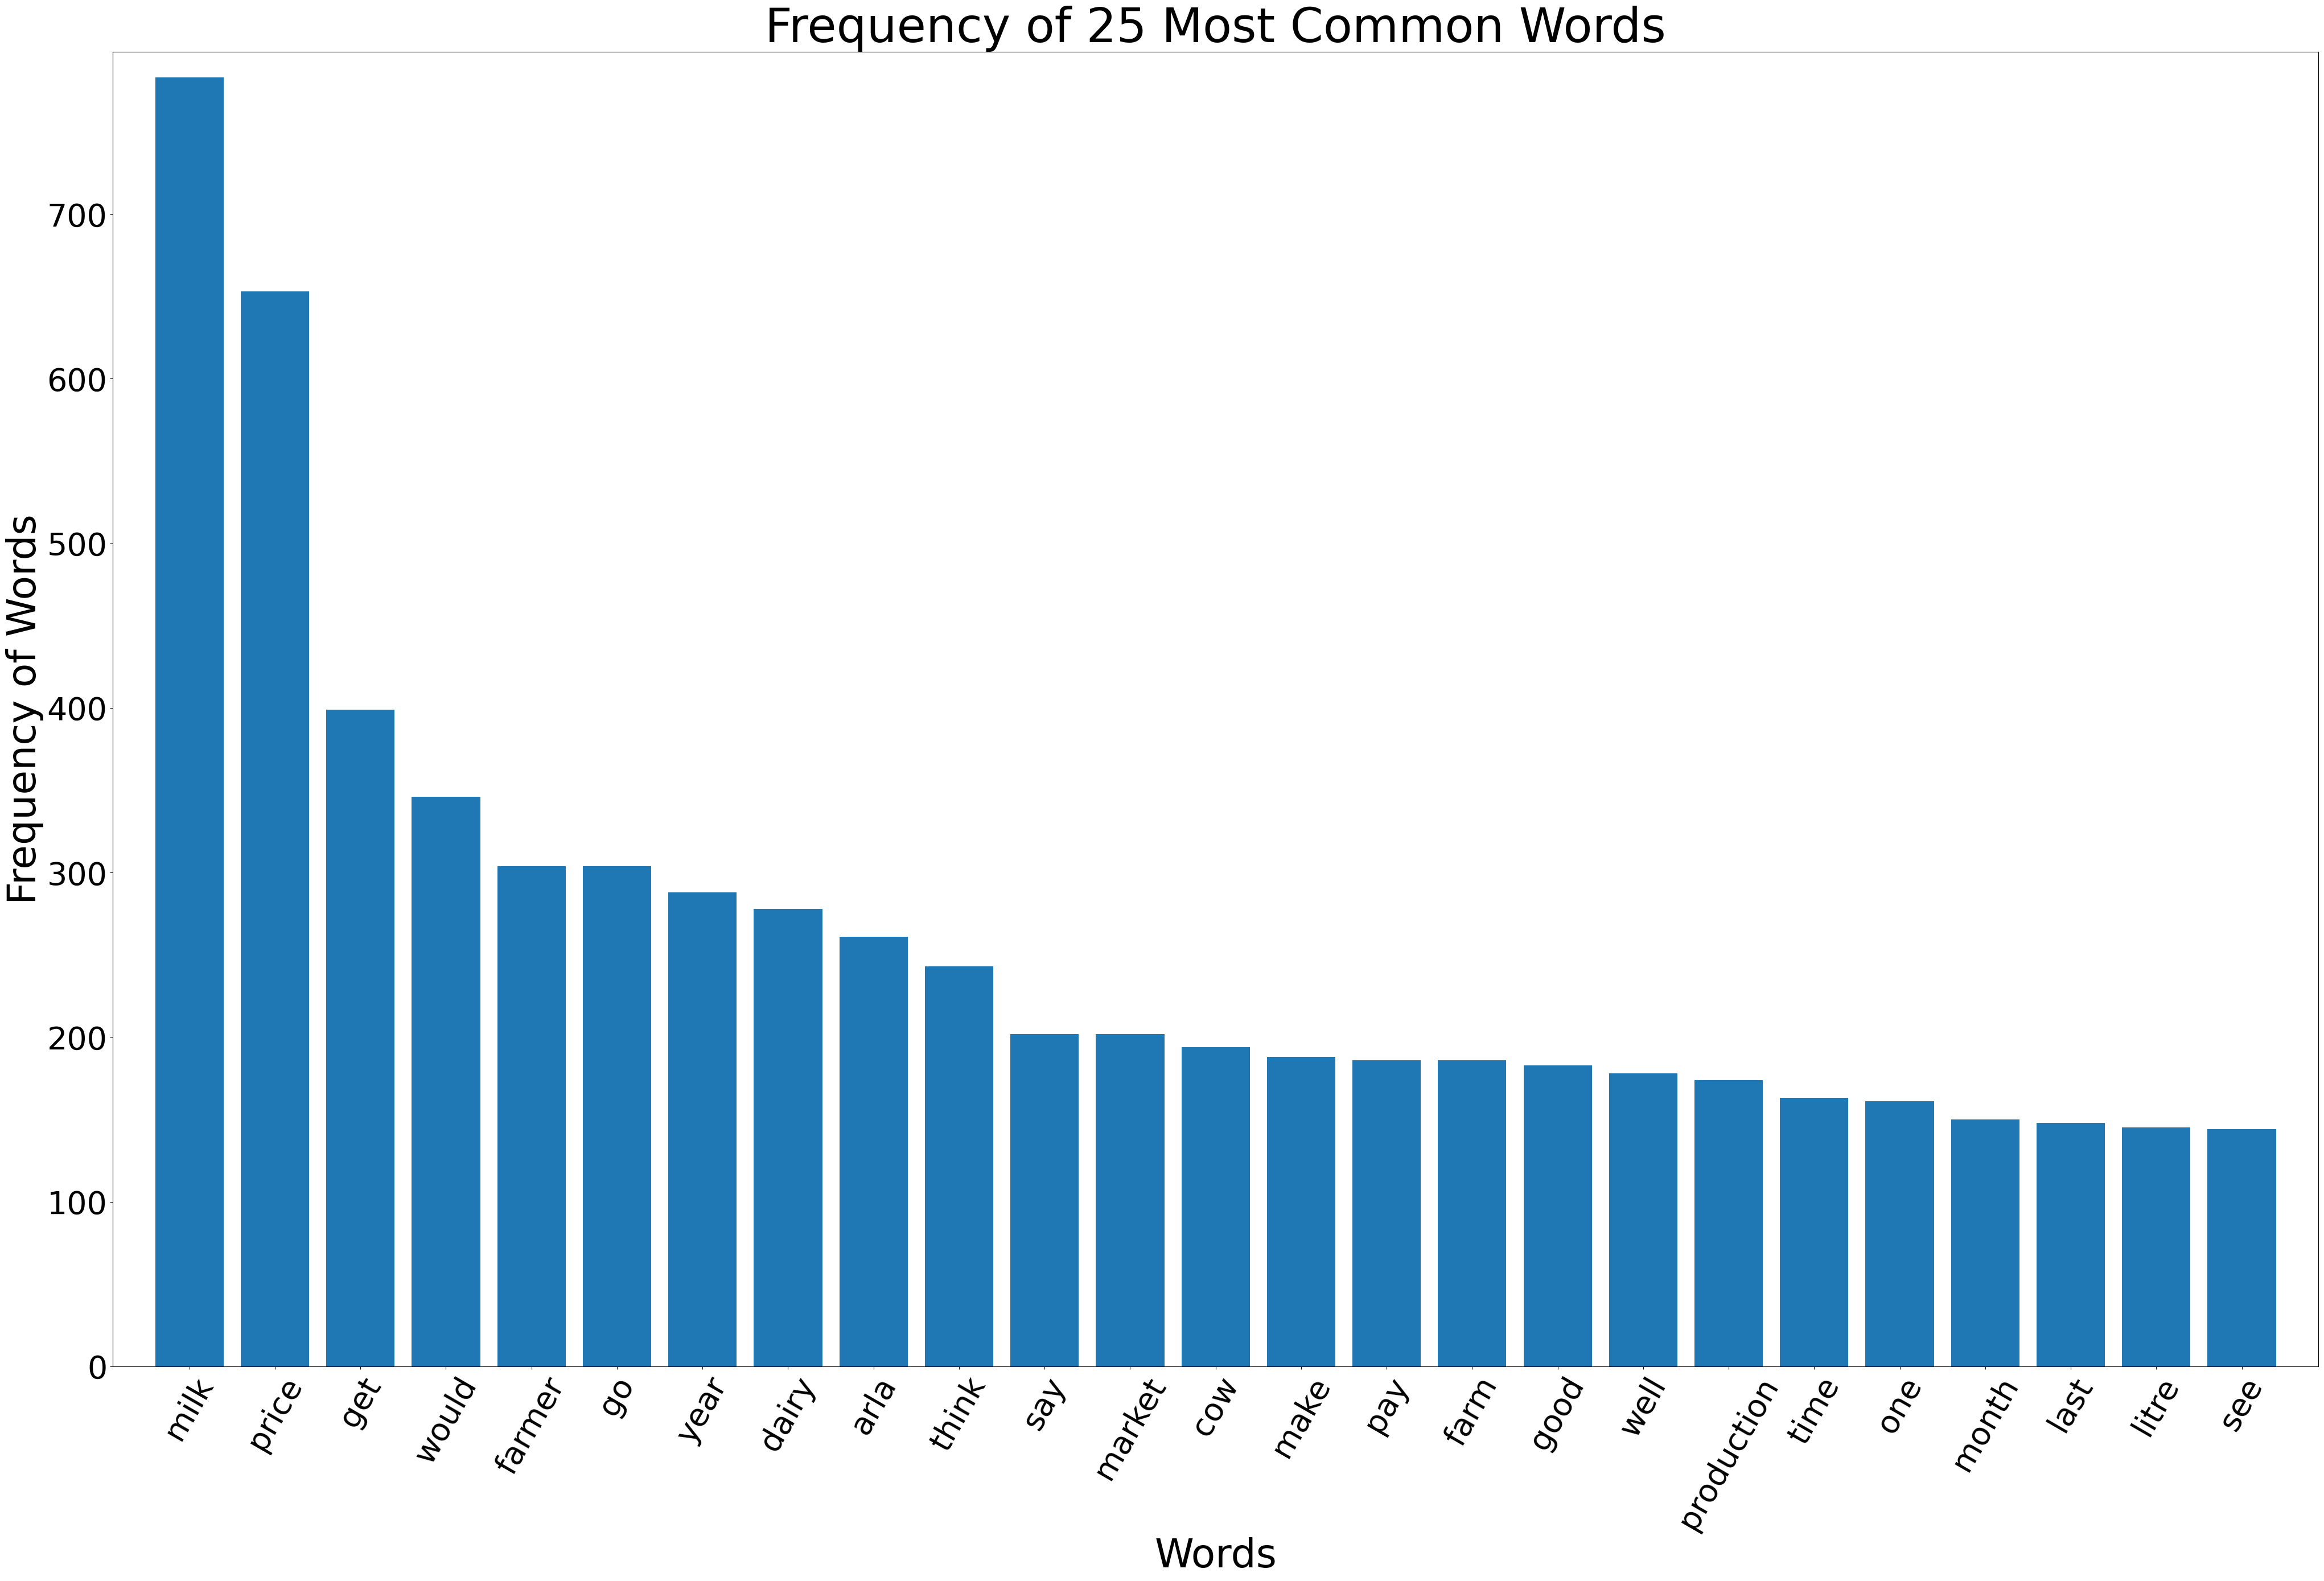

In [10]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

## Extracting the Main Topics

doc-term matrix

In [11]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['lemmatized_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,10,100,12,15,20,23,5ppl,add,ago,agree,...,well,without,work,world,worth,would,wrong,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,3,0,0
1960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)

In [13]:
def Extract_topics(model, feature_names, no_top_words):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        topic_list.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topic_list

In [14]:
def print_topics(_topics_list):
    for topic_idx, topic in enumerate(_topics_list):
        print("topic " + str(topic_idx))
        print(" ".join(topic))

In [15]:
no_top_words = 10
print_topics(Extract_topics(lda_model, tf_feature_names, no_top_words))

topic 0
year last get month new day cow milk time per
topic 1
look come way go today like people try long happen
topic 2
cow get well would could much milk want work know
topic 3
price base average liquid 5ppl rise pay member 15 figure
topic 4
arla contract take producer find time seasonality need current believe
topic 5
milk price production produce low high spring cheese buyer market
topic 6
go think would say one know see another drop yet
topic 7
dairy farmer price milk market supply uk volume cut many
topic 8
good get make big thing money bad sell though like
topic 9
litre pay farm small tesco milk tell business standard yes


In [16]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      52.223595  51.602776       1        1  15.602191
5     -13.455264 -57.715900       2        1  13.273098
0     -50.255013  34.376450       3        1  12.877303
2      12.789710  25.737776       4        1  11.480619
6      45.549374 -59.085613       5        1  10.157833
8     -21.541517  -4.454317       6        1  10.107242
9      -7.859553  68.377762       7        1   7.565712
1      67.354424  -1.164321       8        1   7.226244
4      21.818161 -19.132874       9        1   6.526806
3     -62.354206 -26.909081      10        1   5.182952, topic_info=      Term        Freq       Total Category  logprob  loglift
161  price  657.000000  657.000000  Default  30.0000  30.0000
16    arla  270.000000  270.000000  Default  29.0000  29.0000
133   milk  763.000000  763.000000  Default  28.0000  28.0000
54   dairy  280.000000  280.000000  Default  27.0000  27.0000
238   year  296.000000  296.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
178   rest    0.105526   25.771662  Topic10  -9.1026  -2.5383
128    may    0.105581   79.782544  Topic10  -9.1021  -3.6678
126  march    0.105563   31.689878  Topic10  -9.1023  -2.7446
136  month    0.105555  148.596010  Topic10  -9.1023  -4.2900
80    feel    0.105553   42.522012  Topic10  -9.1024  -3.0388

[400 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         3  0.566470    10
0        10  0.434294    10
1         4  0.214709   100
1         6  0.398745   100
1         7  0.337400   100
...     ...       ...   ...
238       3  0.847717  year
238       4  0.030396  year
239       3  0.343724   yes
239       7  0.638345   yes
240       5  0.982441   yet

[588 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 1, 3, 7, 9, 10, 2, 5, 4])

TF_IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=10, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,000,10,100,1000,10ppl,11,12,13,14,15,...,worry,worth,would,wrong,yeah,year,yes,yesterday,yet,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.228882,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.240546,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.251562,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.152424,0.0,0.0,0.0,0.0
1959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192062,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.349118,0.0,0.0,0.0,0.0
1960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [18]:
nmf = NMF(n_components=10, random_state=0, alpha_W=.0005, init='nndsvd').fit(tfidf)
print_topics(Extract_topics(nmf, tfidf_feature_names, no_top_words))

topic 0
farmer dairy many supply say work crest uk tesco number
topic 1
price pay market drop low base cut month supply say
topic 2
milk first much produce market water make production producer spring
topic 3
get bonus pay big guy litre need start calve week
topic 4
good news bad like quality must cheese contract quite jtt
topic 5
go take way long one keep come back lot wrong
topic 6
would think know drop contract look like see make right
topic 7
well still seem do make may market keep back might
topic 8
arla member currency bacto owner bf scc read producer manufacture
topic 9
year cow last time farm litre month say production one


In [19]:
nmf_topic_values = nmf.transform(tfidf)
df.loc[:, 'nmf_topics'] = nmf_topic_values.argmax(axis=1)
nmf_remap = lambda index: Extract_topics(nmf, tfidf_feature_names, no_top_words)[index]
df.loc[:, 'nmf_topics'] = df['nmf_topics'].map(nmf_remap)

/tmp/ipykernel_40127/1195180015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'nmf_topics'] = nmf_topic_values.argmax(axis=1)


In [20]:
df

,lemmatized,lemmatized_str,sentiment,nmf_topics
0,"[milk, price, tracker, thread, beef, lamb, fee...",milk price tracker thread beef lamb feed fert ...,0.000000,"[price, pay, market, drop, low, base, cut, mon..."
1,"[christ, bad, enough, know, get, would, even, ...",christ bad enough know get would even worse kn...,-0.225000,"[would, think, know, drop, contract, look, lik..."
2,"[would, willing, interesting, see, variation, ...",would willing interesting see variation aroumd...,0.375000,"[would, think, know, drop, contract, look, lik..."
3,"[look, like, start]",look like start,0.000000,"[year, cow, last, time, farm, litre, month, sa..."
4,"[grr, low]",grr low,-0.350000,"[price, pay, market, drop, low, base, cut, mon..."
...,...,...,...,...
1958,"[5, year, 14, 17, unsustainable, unless, cost,...",5 year 14 17 unsustainable unless cost lot sup...,0.350000,"[farmer, dairy, many, supply, say, work, crest..."
1959,"[think, talk, recently, enough, stainless, ste...",think talk recently enough stainless steel han...,0.011111,"[year, cow, last, time, farm, litre, month, sa..."
1960,"[slow, respond, though, many, thought, could, ...",slow respond though many thought could produce...,0.100000,"[get, bonus, pay, big, guy, litre, need, start..."
1961,"[oh, great.now, brussels, allow, state, aid, p...",oh great.now brussels allow state aid producer...,0.200000,"[get, bonus, pay, big, guy, litre, need, start..."
